# Home Credit Default Risk - Machine Learning Project

## Project Overview
- Predict loan default risk using historical credit data.
- Objectives: Improve financial risk assessment, reduce losses for lenders.

# Processing `installments_payments.csv` (Loan Repayment Behavior)

## 1. Load Data (`installments_payments.csv`)

In [61]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [62]:
# Load dataset 
df_installments_payments = pd.read_csv("/kaggle/input/home-credit-default-risk/installments_payments.csv")

## 2. Initial Data Inspection (`installments_payments.csv`)

In [63]:
# Check for infinite values
print("🔍 Checking for infinite values in dataset...")
inf_count = (df_installments_payments == np.inf).sum().sum()
neg_inf_count = (df_installments_payments == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

🔍 Checking for infinite values in dataset...
✅ No infinite values detected.


In [64]:
# 🔍 Check for missing values
missing_values = df_installments_payments.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

⚠️ Missing values detected in columns:
DAYS_ENTRY_PAYMENT    2905
AMT_PAYMENT           2905
dtype: int64


In [65]:
# 📋 Print column names
print(df_installments_payments.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')


In [66]:
# Check for extreme values using percentile-based thresholds 
print("Checking for extreme values in 'installments_payments' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_CURR', 'SK_ID_PREV']
extreme_numeric_columns = df_installments_payments.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'installments_payments' dataset.")

Checking for extreme values in 'installments_payments' dataset using percentile thresholds...
⚠️ Columns with very large values (above 99th percentile):
NUM_INSTALMENT_VERSION        178.000
NUM_INSTALMENT_NUMBER         277.000
DAYS_INSTALMENT                -1.000
DAYS_ENTRY_PAYMENT             -1.000
AMT_INSTALMENT            3771487.845
AMT_PAYMENT               3771487.845
dtype: float64
⚠️ Columns with very small values (below 1st percentile):
DAYS_INSTALMENT      -2922.0
DAYS_ENTRY_PAYMENT   -4921.0
AMT_INSTALMENT           0.0
AMT_PAYMENT              0.0
dtype: float64


In [67]:
# Check the shape of the dataset
print("DataFrame Shape:", df_installments_payments.shape)

DataFrame Shape: (13605401, 8)


In [68]:
# Display the first few rows
print("First few rows of installments_payments DataFrame:")
display(df_installments_payments.head())

First few rows of installments_payments DataFrame:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [69]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_installments_payments.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [70]:
# Get summary statistics of columns
print("\nDescriptive Statistics:")
display(df_installments_payments.describe())

# Check for categorical columns before describing
categorical_cols = df_installments_payments.select_dtypes(include=["object"]).columns
if len(categorical_cols) > 0:
    print("\nDescriptive Statistics (Categorical):")
    display(df_installments_payments.describe(include="object"))
else:
    print("\n✅ No categorical columns in the dataset.")


Descriptive Statistics:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



✅ No categorical columns in the dataset.


## 3. Initial Data Cleaning (`installments_payments.csv`)

In [71]:
# Replace infinite values with NaN before handling missing values
df_installments_payments.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


In [72]:
# Check for potential categorical columns
categorical_candidates = df_installments_payments.select_dtypes(include=['object']).columns.tolist()

# Check numeric columns with low unique values (possible categorical)
low_unique_counts = df_installments_payments.nunique()
numeric_categoricals = low_unique_counts[(low_unique_counts < 20) & (df_installments_payments.dtypes != 'object')].index.tolist()

# Combine detected categorical columns
final_categorical_columns = categorical_candidates + numeric_categoricals

# Convert detected columns to 'category' dtype if any exist
if final_categorical_columns:
    df_installments_payments[final_categorical_columns] = df_installments_payments[final_categorical_columns].astype("category")
    print(f"✅ Converted categorical columns: {final_categorical_columns}")
else:
    print("✅ No categorical columns detected in this dataset. No dtype conversion needed.")

✅ No categorical columns detected in this dataset. No dtype conversion needed.


In [73]:
print("🔍 Unique values in categorical columns:")
if final_categorical_columns:
    for col in final_categorical_columns:
        print(f"{col}: {df_installments_payments[col].nunique()} unique values")
else:
    print("✅ No categorical columns in this dataset.")

🔍 Unique values in categorical columns:
✅ No categorical columns in this dataset.


In [74]:
# 🔍 Checking if float columns contain decimal values
print("\n🔍 Checking if float columns contain decimal values:")

# Identify all float columns
float_cols = df_installments_payments.select_dtypes(include=['float']).columns

# Count the number of rows in each float column that contain decimal values
decimal_counts = df_installments_payments[float_cols].map(lambda x: x % 1 != 0).sum()

# Print results
print(decimal_counts)


🔍 Checking if float columns contain decimal values:
NUM_INSTALMENT_VERSION           0
DAYS_INSTALMENT                  0
DAYS_ENTRY_PAYMENT            2905
AMT_INSTALMENT            11714842
AMT_PAYMENT               11601454
dtype: int64


In [75]:
# Extract unique decimal values
print("\n🔍 Checking unique decimal values:")
for col in float_cols:
    unique_decimals = df_installments_payments[col].dropna().map(lambda x: x % 1).unique()
    print(f"{col}: {unique_decimals}")


🔍 Checking unique decimal values:
NUM_INSTALMENT_VERSION: [0.]
DAYS_INSTALMENT: [0.]
DAYS_ENTRY_PAYMENT: [0.]
AMT_INSTALMENT: [0.36  0.525 0.    ... 0.45  0.66  0.72 ]
AMT_PAYMENT: [0.36  0.525 0.    ... 0.45  0.66  0.72 ]


In [76]:
# Convert integer-like columns to 'Int64'
int_columns = ['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT']
df_installments_payments[int_columns] = df_installments_payments[int_columns].astype('Int64')

print(f"✅ Converted {int_columns} to Int64.")

✅ Converted ['NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT'] to Int64.


In [77]:
# 🔍 Check if the decimal values in DAYS_ENTRY_PAYMENT correspond to missing values
missing_values = df_installments_payments["DAYS_ENTRY_PAYMENT"].isna().sum()
decimal_values = (df_installments_payments["DAYS_ENTRY_PAYMENT"] % 1 != 0).sum()

print(f"🔍 Missing values (NaNs) in DAYS_ENTRY_PAYMENT: {missing_values}")
print(f"🔍 Decimal values in DAYS_ENTRY_PAYMENT: {decimal_values}")

🔍 Missing values (NaNs) in DAYS_ENTRY_PAYMENT: 2905
🔍 Decimal values in DAYS_ENTRY_PAYMENT: 2905


In [78]:
# 🔧 If all decimal values match missing values, convert to Int64
if decimal_values == missing_values:
    df_installments_payments["DAYS_ENTRY_PAYMENT"] = df_installments_payments["DAYS_ENTRY_PAYMENT"].astype('Int64')
    print("✅ Converted DAYS_ENTRY_PAYMENT to Int64.")

✅ Converted DAYS_ENTRY_PAYMENT to Int64.


In [79]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_installments_payments.dtypes)
pd.reset_option('display.max_rows')

✅ Updated Data Types:
SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION      Int64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT             Int64
DAYS_ENTRY_PAYMENT          Int64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object


### Missing Values Handling

In [80]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("🔍 Missing values in each column:")
print(df_installments_payments.isnull().sum())
pd.reset_option('display.max_rows')

🔍 Missing values in each column:
SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64


In [81]:
# Define missing value thresholds (scaled to percentage)
low_threshold = 1  # Less than 1% missing
moderate_threshold = 20  # Between 1% and 20% missing
high_threshold = 50  # More than 50% missing 

# Calculate missing value percentage
missing_percent = (df_installments_payments.isnull().sum() / len(df_installments_payments)) * 100  

# Display missing percentages
print("🔍 Missing Value Percentages:")
display(missing_percent[missing_percent > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%"))

🔍 Missing Value Percentages:


DAYS_ENTRY_PAYMENT    0.02%
AMT_PAYMENT           0.02%
dtype: object

In [82]:
# Identify columns to drop (more than 50% missing values)
columns_to_drop = missing_percent[missing_percent > high_threshold].index

# Drop columns
df_installments_payments.drop(columns=columns_to_drop, inplace=True)

print(f"✅ Dropped {len(columns_to_drop)} columns with more than 50% missing values: {list(columns_to_drop)}")

✅ Dropped 0 columns with more than 50% missing values: []


In [83]:
# Fill numeric columns with median
numeric_cols_to_fill = df_installments_payments.select_dtypes(include=['int64', 'float64']).columns
df_installments_payments[numeric_cols_to_fill] = df_installments_payments[numeric_cols_to_fill].fillna(df_installments_payments[numeric_cols_to_fill].median())

print("✅ Filled numeric missing values with median.")

✅ Filled numeric missing values with median.


In [84]:
# 🔍 Final Missing Values Check
print("🔍 Final Missing Values Check:")
print(df_installments_payments.isnull().sum().sum())

🔍 Final Missing Values Check:
0


In [85]:
# Check for duplicates
print("🔍 Number of duplicate rows:", df_installments_payments.duplicated().sum())

🔍 Number of duplicate rows: 0


## 4. Exploratory Data Analysis (`installments_payments.csv`)

In [86]:
### Summary Statistics
pd.set_option('display.max_columns', None)

# Numeric summary
print("🔍 Summary Statistics (Numeric Features):")
display(df_installments_payments.describe().T)

pd.reset_option('display.max_columns')

🔍 Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,13605401.0,1903364.969549,536202.905546,1000001.0,1434191.0,1896520.0,2369094.0,2843499.0
SK_ID_CURR,13605401.0,278444.881738,102718.310411,100001.0,189639.0,278685.0,367530.0,456255.0
NUM_INSTALMENT_VERSION,13605401.0,0.856637,1.035216,0.0,0.0,1.0,1.0,178.0
NUM_INSTALMENT_NUMBER,13605401.0,18.870896,26.664067,1.0,4.0,8.0,19.0,277.0
DAYS_INSTALMENT,13605401.0,-1042.269992,800.946284,-2922.0,-1654.0,-818.0,-361.0,-1.0
DAYS_ENTRY_PAYMENT,13605401.0,-1051.065832,800.507106,-4921.0,-1662.0,-827.0,-370.0,-1.0
AMT_INSTALMENT,13605401.0,17050.906989,50570.254429,0.0,4226.085,8884.08,16710.21,3771487.845
AMT_PAYMENT,13605401.0,17236.277521,54730.102077,0.0,3399.3,8125.515,16105.905,3771487.845


### 4.1 Correlation Analysis (`installments_payments.csv`)

In [87]:
# Select only numeric columns from df_installments_payments
numeric_data = df_installments_payments.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Display top 10 most correlated feature pairs (excluding self-correlations)
print("🔍 Top 10 Most Correlated Features in `df_installments_payments`:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
print(corr_pairs.head(10))

🔍 Top 10 Most Correlated Features in `df_installments_payments`:
DAYS_ENTRY_PAYMENT      DAYS_INSTALMENT           0.999395
DAYS_INSTALMENT         DAYS_ENTRY_PAYMENT        0.999395
AMT_PAYMENT             AMT_INSTALMENT            0.937059
AMT_INSTALMENT          AMT_PAYMENT               0.937059
NUM_INSTALMENT_VERSION  AMT_PAYMENT               0.176530
AMT_PAYMENT             NUM_INSTALMENT_VERSION    0.176530
AMT_INSTALMENT          NUM_INSTALMENT_VERSION    0.168109
NUM_INSTALMENT_VERSION  AMT_INSTALMENT            0.168109
DAYS_INSTALMENT         NUM_INSTALMENT_VERSION    0.130244
NUM_INSTALMENT_VERSION  DAYS_INSTALMENT           0.130244
dtype: float64


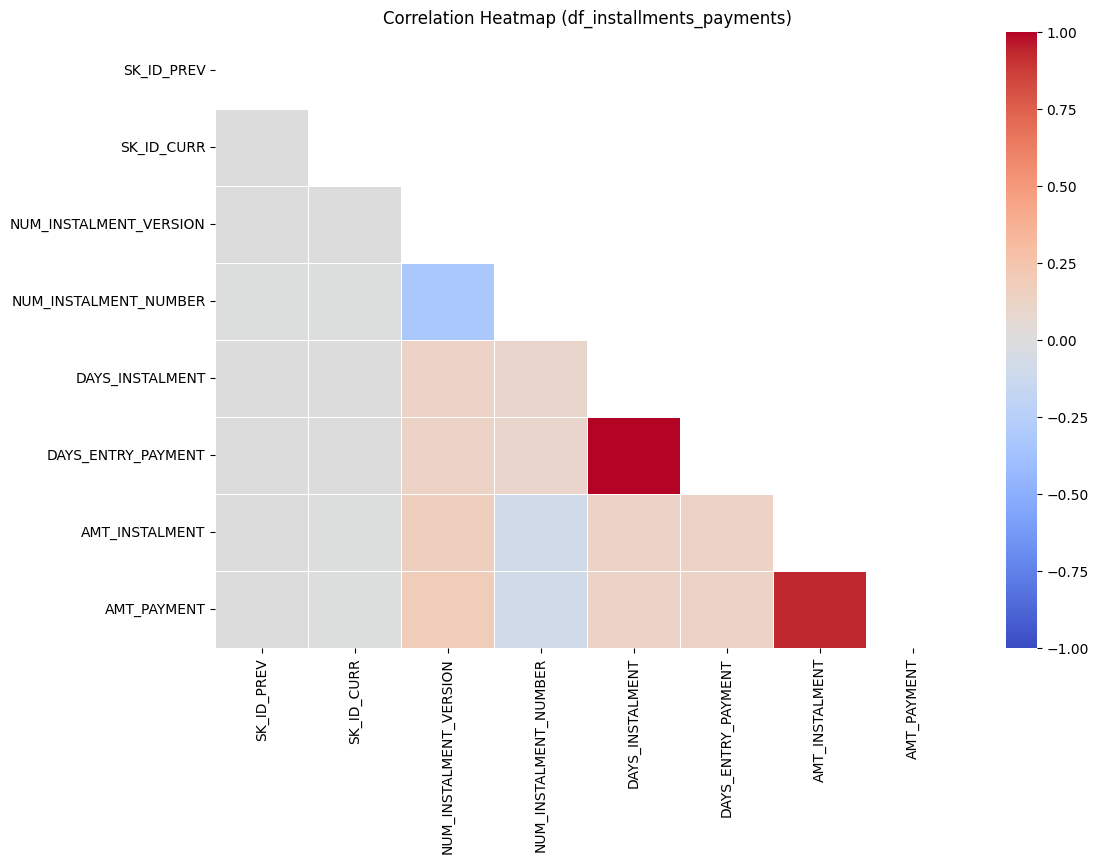

In [88]:
# Visualize the correlation matrix using a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Set figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False, 
    cmap="coolwarm", 
    linewidths=0.5, 
    vmin=-1, vmax=1
)

# Title
plt.title("Correlation Heatmap (df_installments_payments)")
plt.show()

### 4.2 Visualising Outliers (`installments_payments.csv`)

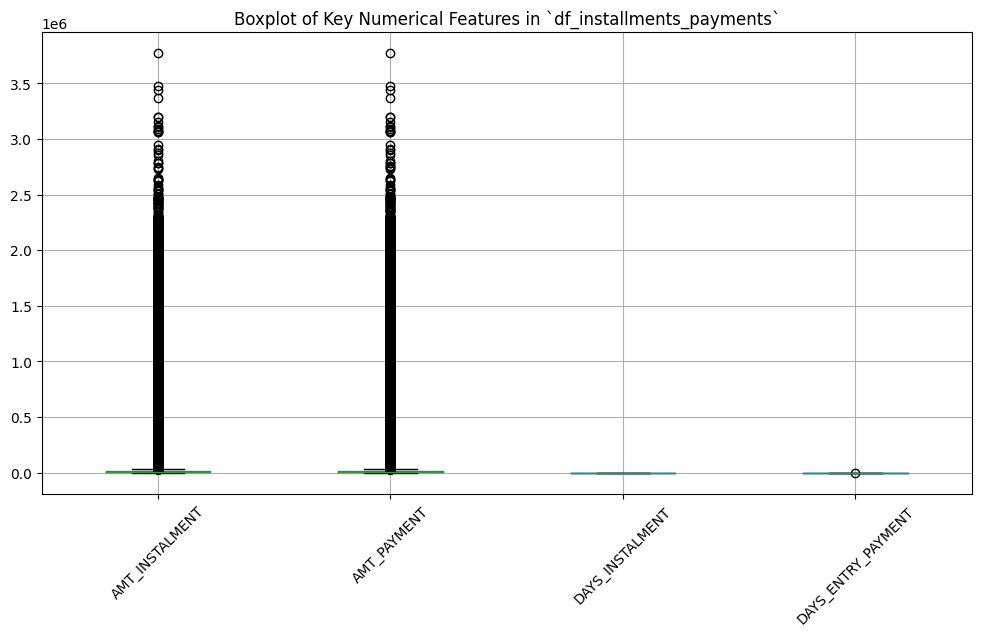

In [89]:
# Selected key numeric features for outlier detection
outlier_columns = [
    "AMT_INSTALMENT", "AMT_PAYMENT", "DAYS_INSTALMENT", "DAYS_ENTRY_PAYMENT"
]

# Create boxplot
plt.figure(figsize=(12, 6))
df_installments_payments[outlier_columns].boxplot()

# Title
plt.title("Boxplot of Key Numerical Features in `df_installments_payments`")
plt.xticks(rotation=45)  
plt.show()

### 4.3 Pair Plot Analysis (`installments_payments.csv`)

Pair plots are not included for this dataset as they are better suited for static features rather than time-series-like transaction data. Instead, we focus on histograms and scatter plots for clearer insights into repayment patterns.

### 4.4 Group-wise Analysis (`installments_payments.csv`)

This dataset does not contain categorical features, so boxplots grouped by categorical variables are not applicable. Instead, we focus on numerical distributions and repayment patterns.

### 4.5 Time-wise Analysis (`installments_payments.csv`)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


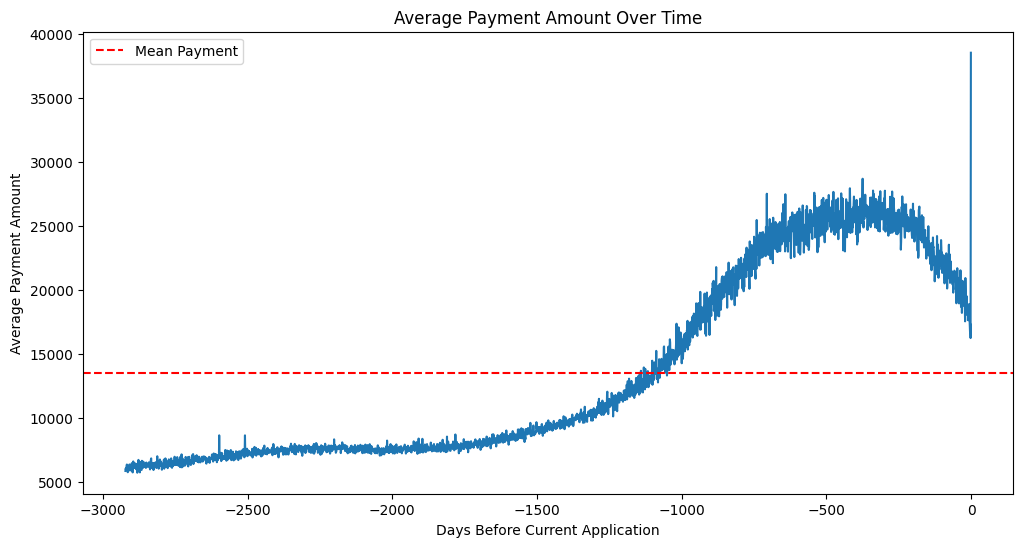

In [90]:
# Average payment amount over time
df_time = df_installments_payments.groupby("DAYS_INSTALMENT")["AMT_PAYMENT"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="DAYS_INSTALMENT", y="AMT_PAYMENT", data=df_time)
plt.axhline(df_time["AMT_PAYMENT"].mean(), linestyle="--", color="red", label="Mean Payment")
plt.title("Average Payment Amount Over Time")
plt.xlabel("Days Before Current Application")
plt.ylabel("Average Payment Amount")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


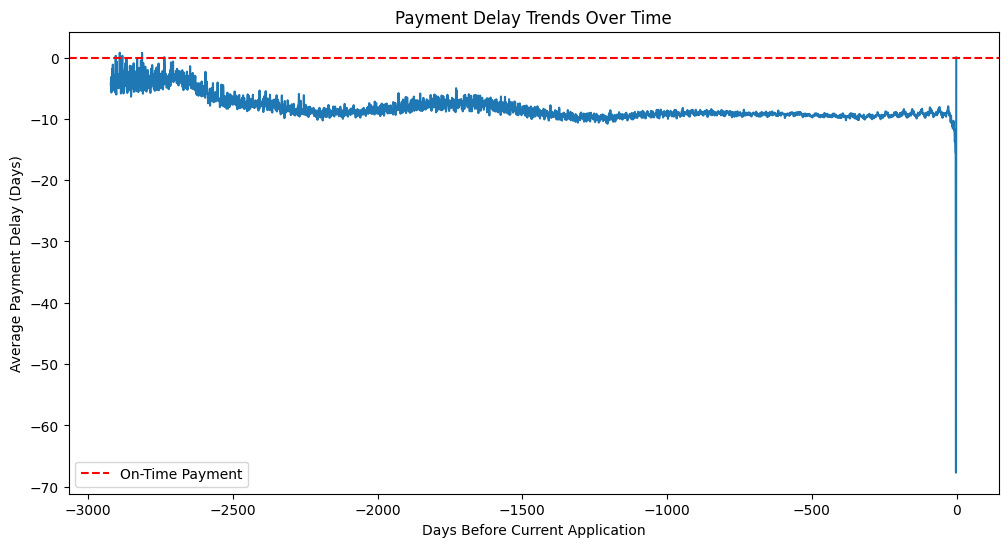

In [91]:
# Payment delays over time
df_time_delay = df_installments_payments.groupby("DAYS_INSTALMENT")["DAYS_ENTRY_PAYMENT"].mean().reset_index()
df_time_delay["PAYMENT_DELAY"] = df_time_delay["DAYS_ENTRY_PAYMENT"] - df_time_delay["DAYS_INSTALMENT"]

plt.figure(figsize=(12, 6))
sns.lineplot(x="DAYS_INSTALMENT", y="PAYMENT_DELAY", data=df_time_delay)
plt.axhline(0, linestyle="--", color="red", label="On-Time Payment")
plt.title("Payment Delay Trends Over Time")
plt.xlabel("Days Before Current Application")
plt.ylabel("Average Payment Delay (Days)")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


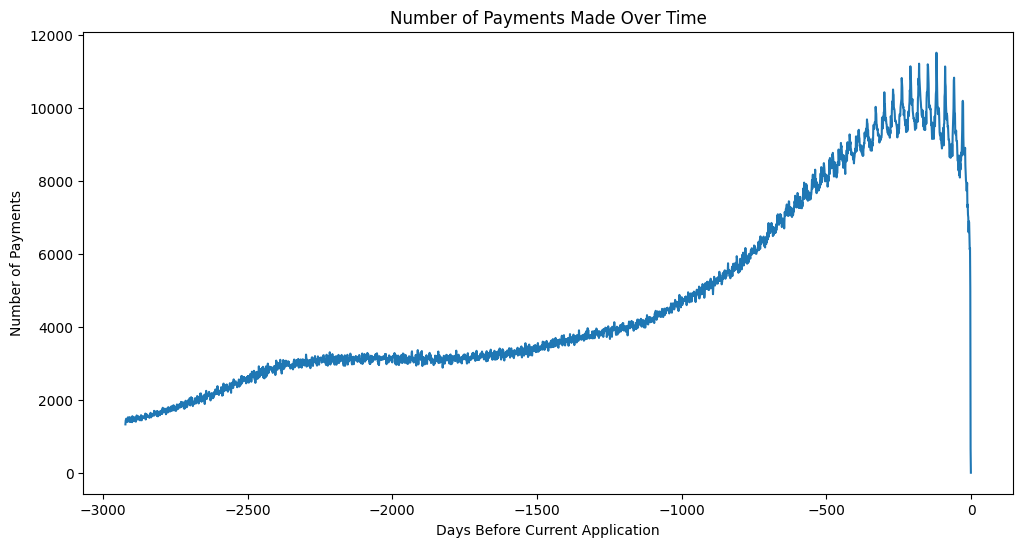

In [92]:
# Total payments made per time period
df_count = df_installments_payments.groupby("DAYS_INSTALMENT")["SK_ID_PREV"].count().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="DAYS_INSTALMENT", y="SK_ID_PREV", data=df_count)
plt.title("Number of Payments Made Over Time")
plt.xlabel("Days Before Current Application")
plt.ylabel("Number of Payments")
plt.show()

### 4.6 Joint Plot Analysis (`installments_payments.csv`)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


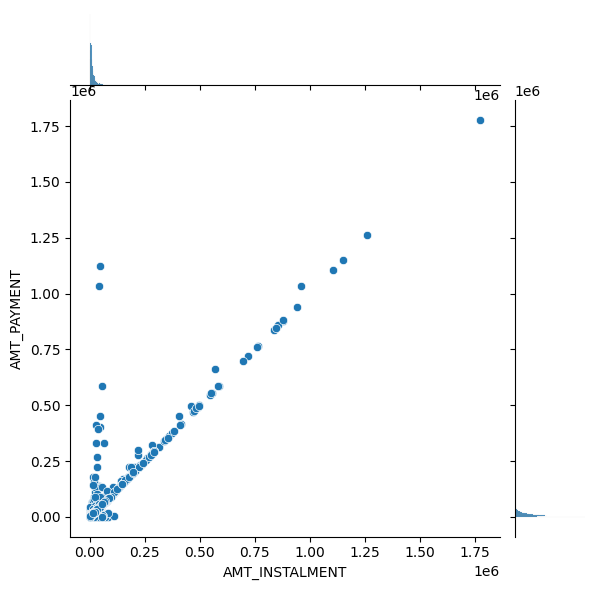

In [93]:
# Sample 10,000 rows for performance
df_sample_scatter = df_installments_payments.sample(n=10000, random_state=42)

# Scatter plot of Expected Installment vs. Actual Payment
sns.jointplot(x="AMT_INSTALMENT", y="AMT_PAYMENT", data=df_sample_scatter, kind="scatter")

plt.title("Scatter Plot: AMT_INSTALMENT vs. AMT_PAYMENT")
plt.show()

### 4.7 Additional EDA Visualisations (`installments_payments.csv`)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


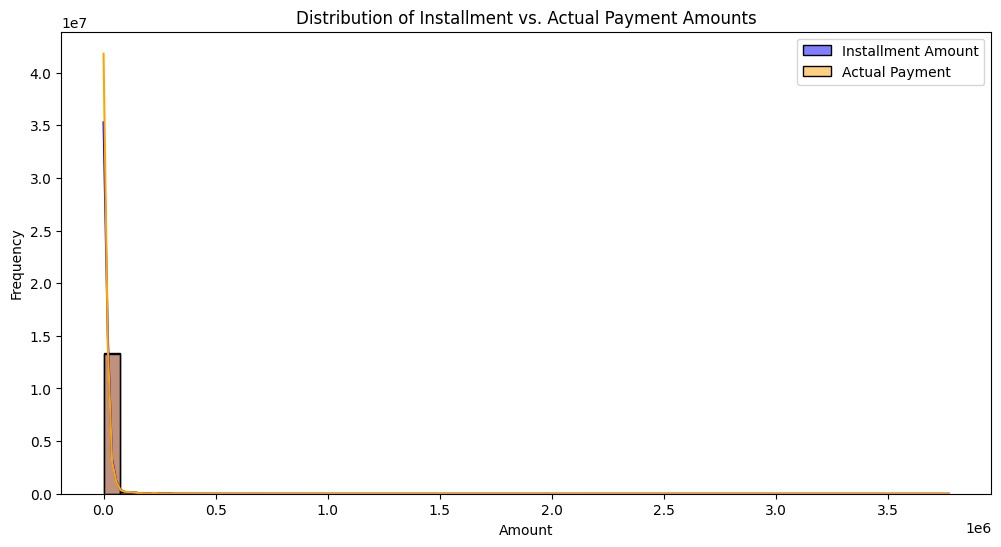

In [94]:
# Payment amount distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_installments_payments["AMT_INSTALMENT"], bins=50, kde=True, color="blue", label="Installment Amount")
sns.histplot(df_installments_payments["AMT_PAYMENT"], bins=50, kde=True, color="orange", label="Actual Payment")
plt.title("Distribution of Installment vs. Actual Payment Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


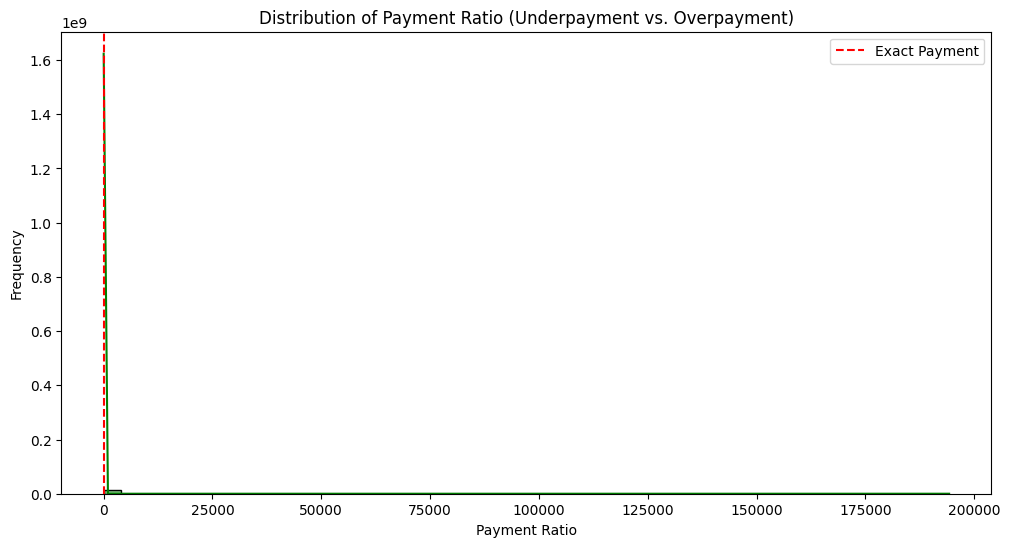

In [95]:
# Payment ratio (underpayment vs. overpayment)
# Safely compute Payment Ratio to prevent division by zero
df_installments_payments["PAYMENT_RATIO"] = df_installments_payments["AMT_PAYMENT"] / df_installments_payments["AMT_INSTALMENT"].replace(0, np.nan)

plt.figure(figsize=(12, 6))
sns.histplot(df_installments_payments["PAYMENT_RATIO"], bins=50, kde=True, color="green")
plt.axvline(1, color="red", linestyle="--", label="Exact Payment")
plt.title("Distribution of Payment Ratio (Underpayment vs. Overpayment)")
plt.xlabel("Payment Ratio")
plt.ylabel("Frequency")
plt.legend()
plt.show()

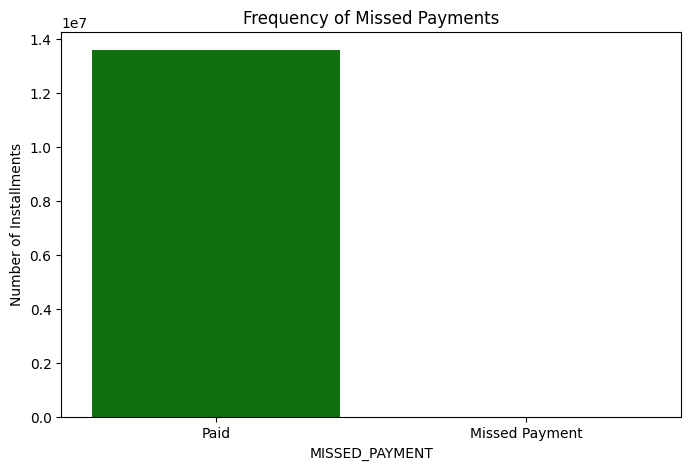

In [96]:
# Missed payments frequency
df_installments_payments["MISSED_PAYMENT"] = (df_installments_payments["AMT_PAYMENT"] == 0).astype(int)

plt.figure(figsize=(8, 5))
sns.barplot(x=df_installments_payments["MISSED_PAYMENT"].value_counts().index, 
            y=df_installments_payments["MISSED_PAYMENT"].value_counts().values, palette=["green", "red"])
plt.xticks([0, 1], ["Paid", "Missed Payment"])
plt.title("Frequency of Missed Payments")
plt.ylabel("Number of Installments")
plt.show()

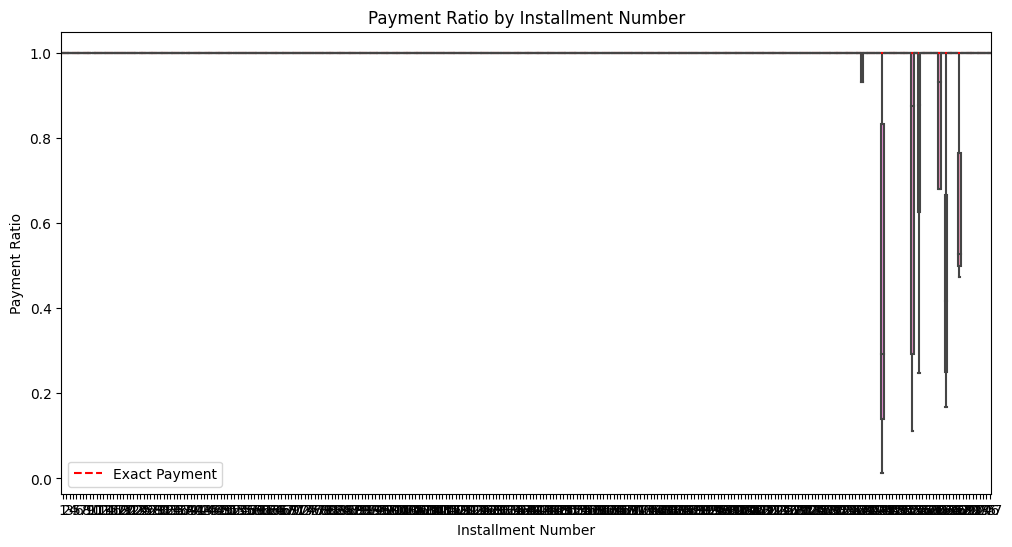

In [97]:
# Payment ratio by installment number
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_installments_payments["NUM_INSTALMENT_NUMBER"], 
            y=df_installments_payments["PAYMENT_RATIO"], showfliers=False)
plt.axhline(1, color="red", linestyle="--", label="Exact Payment")
plt.title("Payment Ratio by Installment Number")
plt.xlabel("Installment Number")
plt.ylabel("Payment Ratio")
plt.legend()
plt.show()

## 5. Feature Engineering (`installments_payments.csv`)

### 5.1 Credit Activity Features (`installments_payments.csv`)

In [98]:
# Group by SK_ID_CURR and calculate credit activity features
installments_credit_activity = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_NUM_PAYMENTS=("SK_ID_PREV", "count"),  # Total number of payments made
    installments_NUM_MISSED_PAYMENTS=("MISSED_PAYMENT", "sum"),  # Total number of missed payments
    installments_MISSED_PAYMENT_RATIO=("MISSED_PAYMENT", lambda x: x.mean())  # Ratio of missed payments
).reset_index()

# Preview the new features before merging
display(installments_credit_activity.head())

,SK_ID_CURR,installments_NUM_PAYMENTS,installments_NUM_MISSED_PAYMENTS,installments_MISSED_PAYMENT_RATIO
0,100001,7,0,0.0
1,100002,19,0,0.0
2,100003,25,0,0.0
3,100004,3,0,0.0
4,100005,9,0,0.0


### 5.2 Loan Amount Features (`installments_payments.csv`)

In [99]:
# Group by SK_ID_CURR and calculate loan amount features
installments_loan_amount = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_MEAN_INSTALMENT_AMOUNT=("AMT_INSTALMENT", "mean"),  # Avg expected installment amount
    installments_MEAN_ACTUAL_PAYMENT=("AMT_PAYMENT", "mean"),  # Avg actual payment made
    installments_SUM_INSTALMENT_AMOUNT=("AMT_INSTALMENT", "sum"),  # Total expected installment amount
    installments_SUM_ACTUAL_PAYMENT=("AMT_PAYMENT", "sum"),  # Total actual paid amount
).reset_index()

# Compute Payment Compliance Ratio (Avoid division by zero)
installments_loan_amount["installments_PAYMENT_COMPLIANCE_RATIO"] = (
    installments_loan_amount["installments_SUM_ACTUAL_PAYMENT"] / installments_loan_amount["installments_SUM_INSTALMENT_AMOUNT"]
)
installments_loan_amount["installments_PAYMENT_COMPLIANCE_RATIO"] = installments_loan_amount["installments_PAYMENT_COMPLIANCE_RATIO"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Preview the new features before merging
display(installments_loan_amount.head())

,SK_ID_CURR,installments_MEAN_INSTALMENT_AMOUNT,installments_MEAN_ACTUAL_PAYMENT,installments_SUM_INSTALMENT_AMOUNT,installments_SUM_ACTUAL_PAYMENT,installments_PAYMENT_COMPLIANCE_RATIO
0,100001,5885.132143,5885.132143,41195.925,41195.925,1.0
1,100002,11559.247105,11559.247105,219625.695,219625.695,1.0
2,100003,64754.586000,64754.586000,1618864.650,1618864.650,1.0
3,100004,7096.155000,7096.155000,21288.465,21288.465,1.0
4,100005,6240.205000,6240.205000,56161.845,56161.845,1.0


### 5.3 Time-Based Features (`installments_payments.csv`)

In [100]:
# Group by SK_ID_CURR and calculate time-based features
installments_time_based = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_MEAN_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "mean"),  # Avg days when payment was made
    installments_STD_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "std"),  # Std deviation (payment consistency)
    installments_MIN_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "min"),  # Earliest payment recorded
    installments_MAX_DAYS_ENTRY_PAYMENT=("DAYS_ENTRY_PAYMENT", "max"),  # Most recent payment recorded
    installments_MEAN_DAYS_INSTALMENT=("DAYS_INSTALMENT", "mean"),  # Avg expected due date of installment
    installments_MIN_DAYS_INSTALMENT=("DAYS_INSTALMENT", "min"),  # Earliest expected due date
    installments_MAX_DAYS_INSTALMENT=("DAYS_INSTALMENT", "max"),  # Most recent due date
).reset_index()

# Compute Additional Temporal Features
installments_time_based["installments_TIME_SINCE_LAST_PAYMENT"] = abs(installments_time_based["installments_MAX_DAYS_ENTRY_PAYMENT"])
installments_time_based["installments_MEAN_PAYMENT_DELAY"] = abs(installments_time_based["installments_MEAN_DAYS_ENTRY_PAYMENT"] - installments_time_based["installments_MEAN_DAYS_INSTALMENT"])

# Preview the new features before merging
display(installments_time_based.head())

,SK_ID_CURR,installments_MEAN_DAYS_ENTRY_PAYMENT,installments_STD_DAYS_ENTRY_PAYMENT,installments_MIN_DAYS_ENTRY_PAYMENT,installments_MAX_DAYS_ENTRY_PAYMENT,installments_MEAN_DAYS_INSTALMENT,installments_MIN_DAYS_INSTALMENT,installments_MAX_DAYS_INSTALMENT,installments_TIME_SINCE_LAST_PAYMENT,installments_MEAN_PAYMENT_DELAY
0,100001,-2195.0,643.904237,-2916,-1628,-2187.714286,-2916,-1619,1628,7.285714
1,100002,-315.421053,172.058877,-587,-49,-295.0,-565,-25,49,20.421053
2,100003,-1385.32,757.325432,-2324,-544,-1378.16,-2310,-536,544,7.16
3,100004,-761.666667,34.019602,-795,-727,-754.0,-784,-724,727,7.666667
4,100005,-609.555556,90.554005,-736,-470,-586.0,-706,-466,470,23.555556


### 5.4 Credit Overdue Features (`installments_payments.csv`)

In [101]:
# Precompute late payment flag (avoids repeated computation)
df_installments_payments["LATE_PAYMENT"] = (df_installments_payments["DAYS_ENTRY_PAYMENT"] > df_installments_payments["DAYS_INSTALMENT"]).astype(int)

# Compute payment delay before aggregation to speed up processing
df_installments_payments["PAYMENT_DELAY"] = df_installments_payments["DAYS_ENTRY_PAYMENT"] - df_installments_payments["DAYS_INSTALMENT"]

# 🔹 Group by SK_ID_CURR and calculate overdue-related statistics efficiently
installments_overdue = df_installments_payments.groupby("SK_ID_CURR").agg(
    installments_MEAN_PAYMENT_DELAY=("PAYMENT_DELAY", "mean"),  # Avg delay in payment
    installments_STD_PAYMENT_DELAY=("PAYMENT_DELAY", "std"),  # Std deviation of delays
    installments_NUM_LATE_PAYMENTS=("LATE_PAYMENT", "sum"),  # Count of late payments
    installments_LATE_PAYMENT_RATIO=("LATE_PAYMENT", "mean")  # Proportion of late payments
).reset_index()

# ✅ Preview the new features before merging
display(installments_overdue.head())

,SK_ID_CURR,installments_MEAN_PAYMENT_DELAY,installments_STD_PAYMENT_DELAY,installments_NUM_LATE_PAYMENTS,installments_LATE_PAYMENT_RATIO
0,100001,-7.285714,14.625483,1,0.142857
1,100002,-20.421053,4.925171,0,0.000000
2,100003,-7.16,3.726929,0,0.000000
3,100004,-7.666667,4.163332,0,0.000000
4,100005,-23.555556,13.510284,1,0.111111


### 5.5 Categorical Features Aggregation (`installments_payments.csv`)

This dataset does not contain categorical features, so this section is skipped to maintain consistency across notebooks.  

## 6. Aggregation (`installments_payments.csv`)

### 6.1 Aggregate All Numeric and Categorical Columns (`installments_payments.csv`)

In [102]:
# 🔹 Aggregate df_installments_payments before merging
print("\n🔄 Aggregating df_installments_payments by SK_ID_CURR...")

# Exclude SK_ID_PREV (installment-level unique identifier)
agg_numeric_columns = df_installments_payments.select_dtypes(include=['number']).drop(columns=['SK_ID_PREV'], errors='ignore')

# 🔹 Aggregate numerical features (without std for cleaner results)
agg_funcs = ['mean', 'sum', 'max', 'min']
agg_numeric = agg_numeric_columns.groupby('SK_ID_CURR').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['installments_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# 🔹 No categorical columns in this dataset, so skip categorical aggregation
df_installments_payments_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_installments_payments_aggregated shape: {df_installments_payments_aggregated.shape}")

# Preview the aggregated dataframe
display(df_installments_payments_aggregated.head())


🔄 Aggregating df_installments_payments by SK_ID_CURR...
✅ Aggregation complete. New df_installments_payments_aggregated shape: (339587, 41)


,SK_ID_CURR,installments_agg_NUM_INSTALMENT_VERSION_mean,installments_agg_NUM_INSTALMENT_VERSION_sum,installments_agg_NUM_INSTALMENT_VERSION_max,installments_agg_NUM_INSTALMENT_VERSION_min,installments_agg_NUM_INSTALMENT_NUMBER_mean,installments_agg_NUM_INSTALMENT_NUMBER_sum,installments_agg_NUM_INSTALMENT_NUMBER_max,installments_agg_NUM_INSTALMENT_NUMBER_min,installments_agg_DAYS_INSTALMENT_mean,...,installments_agg_MISSED_PAYMENT_max,installments_agg_MISSED_PAYMENT_min,installments_agg_LATE_PAYMENT_mean,installments_agg_LATE_PAYMENT_sum,installments_agg_LATE_PAYMENT_max,installments_agg_LATE_PAYMENT_min,installments_agg_PAYMENT_DELAY_mean,installments_agg_PAYMENT_DELAY_sum,installments_agg_PAYMENT_DELAY_max,installments_agg_PAYMENT_DELAY_min
0,100001,1.142857,8,2,1,2.714286,19,4,1,-2187.714286,...,0,0,0.142857,1,1,0,-7.285714,-51,11,-36
1,100002,1.052632,20,2,1,10.000000,190,19,1,-295.0,...,0,0,0.000000,0,0,0,-20.421053,-388,-12,-31
2,100003,1.04,26,2,1,5.080000,127,12,1,-1378.16,...,0,0,0.000000,0,0,0,-7.16,-179,-1,-14
3,100004,1.333333,4,2,1,2.000000,6,3,1,-754.0,...,0,0,0.000000,0,0,0,-7.666667,-23,-3,-11
4,100005,1.111111,10,2,1,5.000000,45,9,1,-586.0,...,0,0,0.111111,1,1,0,-23.555556,-212,1,-37


In [103]:
# 🔍 Check aggregation results
print("Unique Clients in df_installments_payments:", df_installments_payments["SK_ID_CURR"].nunique())
print("Rows in df_installments_payments_aggregated:", df_installments_payments_aggregated.shape[0])
display(df_installments_payments_aggregated.head())

Unique Clients in df_installments_payments: 339587
Rows in df_installments_payments_aggregated: 339587


,SK_ID_CURR,installments_agg_NUM_INSTALMENT_VERSION_mean,installments_agg_NUM_INSTALMENT_VERSION_sum,installments_agg_NUM_INSTALMENT_VERSION_max,installments_agg_NUM_INSTALMENT_VERSION_min,installments_agg_NUM_INSTALMENT_NUMBER_mean,installments_agg_NUM_INSTALMENT_NUMBER_sum,installments_agg_NUM_INSTALMENT_NUMBER_max,installments_agg_NUM_INSTALMENT_NUMBER_min,installments_agg_DAYS_INSTALMENT_mean,...,installments_agg_MISSED_PAYMENT_max,installments_agg_MISSED_PAYMENT_min,installments_agg_LATE_PAYMENT_mean,installments_agg_LATE_PAYMENT_sum,installments_agg_LATE_PAYMENT_max,installments_agg_LATE_PAYMENT_min,installments_agg_PAYMENT_DELAY_mean,installments_agg_PAYMENT_DELAY_sum,installments_agg_PAYMENT_DELAY_max,installments_agg_PAYMENT_DELAY_min
0,100001,1.142857,8,2,1,2.714286,19,4,1,-2187.714286,...,0,0,0.142857,1,1,0,-7.285714,-51,11,-36
1,100002,1.052632,20,2,1,10.000000,190,19,1,-295.0,...,0,0,0.000000,0,0,0,-20.421053,-388,-12,-31
2,100003,1.04,26,2,1,5.080000,127,12,1,-1378.16,...,0,0,0.000000,0,0,0,-7.16,-179,-1,-14
3,100004,1.333333,4,2,1,2.000000,6,3,1,-754.0,...,0,0,0.000000,0,0,0,-7.666667,-23,-3,-11
4,100005,1.111111,10,2,1,5.000000,45,9,1,-586.0,...,0,0,0.111111,1,1,0,-23.555556,-212,1,-37


## 7. Merging (`installments_payments.csv`)

In [104]:
# 🔹 Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_CURR", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    missing_values = df_main.isnull().sum()[df_main.isnull().sum() > 0]
    
    if not missing_values.empty:
        print(f"🛠️ Missing Values in {name} After Merge:\n{missing_values}")
    
    print("-" * 50)
    return df_main

# 🔹 Apply Safe Merges for Installments Payments Features
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_credit_activity, name="installments_credit_activity")
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_loan_amount, name="installments_loan_amount")
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_time_based, name="installments_time_based")
df_installments_payments_aggregated = safe_merge(df_installments_payments_aggregated, installments_overdue, name="installments_overdue")

print("✅ All installments payments feature tables merged successfully!")

✅ Merged installments_credit_activity: (339587, 41) -> (339587, 44)
🛠️ Missing Values in installments_credit_activity After Merge:
installments_agg_PAYMENT_RATIO_mean    3
installments_agg_PAYMENT_RATIO_max     3
installments_agg_PAYMENT_RATIO_min     3
dtype: int64
--------------------------------------------------
✅ Merged installments_loan_amount: (339587, 44) -> (339587, 49)
🛠️ Missing Values in installments_loan_amount After Merge:
installments_agg_PAYMENT_RATIO_mean    3
installments_agg_PAYMENT_RATIO_max     3
installments_agg_PAYMENT_RATIO_min     3
dtype: int64
--------------------------------------------------
✅ Merged installments_time_based: (339587, 49) -> (339587, 58)
🛠️ Missing Values in installments_time_based After Merge:
installments_agg_PAYMENT_RATIO_mean      3
installments_agg_PAYMENT_RATIO_max       3
installments_agg_PAYMENT_RATIO_min       3
installments_STD_DAYS_ENTRY_PAYMENT    972
dtype: int64
--------------------------------------------------
✅ Merged instal

In [105]:
# Handle NaNs in standard deviation columns by filling with 0
df_installments_payments_aggregated["installments_STD_DAYS_ENTRY_PAYMENT"] = df_installments_payments_aggregated["installments_STD_DAYS_ENTRY_PAYMENT"].fillna(0)
df_installments_payments_aggregated["installments_STD_PAYMENT_DELAY"] = df_installments_payments_aggregated["installments_STD_PAYMENT_DELAY"].fillna(0)

# Handle NaNs in Payment Ratio Aggregates
# Since missing values in PAYMENT_RATIO occur when AMT_INSTALMENT == 0, we assume full payment was made
df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_mean"] = df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_mean"].fillna(1)
df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_max"] = df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_max"].fillna(1)
df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_min"] = df_installments_payments_aggregated["installments_agg_PAYMENT_RATIO_min"].fillna(1)

### 7.1 Feature Validation (`installments_payments.csv`)

In [106]:
# Step 1: Check for standard NaN values
missing_values_installments_aggregated = df_installments_payments_aggregated.isna().sum()
missing_values_installments_aggregated = missing_values_installments_aggregated[missing_values_installments_aggregated > 0]

print("\n🔍 Standard Missing Values in Aggregated Installments Payments Features After Merging:")
print(missing_values_installments_aggregated if not missing_values_installments_aggregated.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or "nan" stored as a string)
hidden_nans_installments_aggregated = (df_installments_payments_aggregated == "").sum() + (df_installments_payments_aggregated == "nan").sum()
hidden_nans_installments_aggregated = hidden_nans_installments_aggregated[hidden_nans_installments_aggregated > 0]

print("\n🔍 Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Installments Payments Features After Merging:")
print(hidden_nans_installments_aggregated if not hidden_nans_installments_aggregated.empty else "✅ No hidden NaNs detected.")


🔍 Standard Missing Values in Aggregated Installments Payments Features After Merging:
✅ No standard NaN values detected.

🔍 Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated Installments Payments Features After Merging:
✅ No hidden NaNs detected.


In [107]:
# Step 3: Check for Inf values
inf_values_installments_aggregated = df_installments_payments_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_installments_aggregated = inf_values_installments_aggregated[inf_values_installments_aggregated > 0]

print("\n🔍 Infinite Values in Aggregated Installments Payments Features After Merging:")
if inf_values_installments_aggregated.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_installments_aggregated)


🔍 Infinite Values in Aggregated Installments Payments Features After Merging:
✅ No Inf values detected.


In [108]:
# Save aggregated installments payments dataset
df_installments_payments_aggregated.to_csv("installments_payments_aggregated.csv", index=False)
df_installments_payments_aggregated.to_pickle("installments_payments_aggregated.pkl")

print("✅ Installments Payments aggregated dataset saved successfully!")

✅ Installments Payments aggregated dataset saved successfully!
